In [1]:
# 3rd party
import sympy as sp
import numpy as np
from IPython.utils.io import capture_output
from IPython.display import display, Latex
import matplotlib.pyplot as plt

# Our stuff
import mainframe as mf
import nuclei_func as nf
from mainframe import Region

In [2]:
################################################################################
# INPUT DATA
################################################################################
micro_abs_water = 0.66
micro_abs_U235 = 678
micro_fiss_U235 = 577

density_water = 1
density_U235 = 19.1

# Defining the temperature correction factor
def T_correction(T_new):
    return np.sqrt(293/(T_new+273))

# Defining the enrichment as a symbol
qual = 1.41516177519707e-5 #From exercise 1

# Defining the macroscopic cross sections of the mixtures
macro_abs_refl = micro_abs_water * (1-qual) * T_correction(20)

# Defining the macroscopic cross sections of the core
macro_fiss = nf.mixture([micro_fiss_U235, 0], [qual, 1-qual]) * T_correction(60)
macro_abs_core = nf.mixture([micro_abs_water, micro_abs_U235], [1-qual, qual]) * T_correction(60)

In [3]:

################################################################################
# Defining the regions
################################################################################
W_Core = sp.symbols('W_Core', positive=True, real=True) # Unknown width of the core
symmetrical_problem = False
Core_1 = Region(
    Diff=0.16, 
    Abs=macro_abs_core, 
    Fiss=macro_fiss, 
    Nu=2.44, 
    Pos1=0, 
    Pos2=W_Core, 
    composition='c', 
    power=25*W_Core # We assumed the same power density as in the exercise 1
)

Reflector_1 = Region(
    Diff=0.16, 
    Abs=macro_abs_refl, 
    Fiss=0, 
    Nu=0, 
    Pos1=W_Core, 
    Pos2=sp.oo, 
    composition='r', 
    power=0
)
regions = [Core_1, Reflector_1]

In [4]:
################################################################################
# Solve the problem
################################################################################
with capture_output() as captured: # To hide debug output
    equations, fluxes, boundaries, interfaces, powers = mf.main(regions, symmetrical_problem)

# Show the system
system = fluxes + boundaries + interfaces + powers
for eq in system:
    display(eq)

Eq(phi_1(x), C_1*sin(Bg_1*x) + C_2*cos(Bg_1*x))

Eq(phi_2(-W_Core + x), C_3*exp(-(-W_Core + x)/L_2) + C_4*exp((-W_Core + x)/L_2))

Eq(C_2, 0)

Eq(C_4, 0)

Eq(C_1*sin(Bg_1*x_1) + C_2*cos(Bg_1*x_1), C_3*exp(-(-W_Core + x_1)/L_2) + C_4*exp((-W_Core + x_1)/L_2))

Eq(-D_1*(Bg_1*C_1*cos(Bg_1*x_1) - Bg_1*C_2*sin(Bg_1*x_1)), -D_2*(-C_3*exp(-(-W_Core + x_1)/L_2)/L_2 + C_4*exp((-W_Core + x_1)/L_2)/L_2))

Eq(-2.59546072003408e-13*C_1*cos(Bg_1*W_Core)/Bg_1 + 2.59546072003408e-13*C_1/Bg_1 + 2.59546072003408e-13*C_2*sin(Bg_1*W_Core)/Bg_1, 25*W_Core)

In [5]:
################################################################################
# Substitute known values
################################################################################
with capture_output() as captured:
    system = mf.compute(system, regions)

# Get rid of any True expressions resulting from =zero conditions
system_cleaned = []
for eq in system:
    if eq != True:
        system_cleaned.append(eq)
        display(eq)
system = system_cleaned

Eq(phi_1(x), C_1*sin(Bg_1*x))

Eq(phi_2(-W_Core + x), C_3*exp(-(-W_Core + x)/L_2))

Eq(C_1*sin(Bg_1*W_Core), C_3)

Eq(-0.16*Bg_1*C_1*cos(Bg_1*W_Core), 0.16*C_3/L_2)

Eq(-2.59546072003408e-13*C_1*cos(Bg_1*W_Core)/Bg_1 + 2.59546072003408e-13*C_1/Bg_1, 25*W_Core)

In [6]:
################################################################################
# Substitute Bg in the system
################################################################################
Bg_1 = sp.symbols('Bg_1', positive=True)
Bg_1_val = 0.05624
L_2 = sp.symbols('L_2', positive=True)
L_2_val = np.sqrt(Reflector_1.Diffusion / macro_abs_refl)

for i, eq in enumerate(system):
    eq = eq.subs(Bg_1, Bg_1_val)
    eq = eq.subs(L_2, L_2_val)
    system[i] = eq
    display(eq)

Eq(phi_1(x), C_1*sin(0.05624*x))

Eq(phi_2(-W_Core + x), C_3*exp(2.03099523007238*W_Core - 2.03099523007238*x))

Eq(C_1*sin(0.05624*W_Core), C_3)

Eq(-0.0089984*C_1*cos(0.05624*W_Core), 0.324959236811581*C_3)

Eq(-4.61497283078606e-12*C_1*cos(0.05624*W_Core) + 4.61497283078606e-12*C_1, 25*W_Core)

In [7]:
################################################################################
# Criticality condition
################################################################################
eq_1 = system[2] # Condition on the flux
eq_2 = system[3] # Condition on the current

# Solve the system
ratio = sp.Eq(eq_1.lhs / eq_2.lhs, eq_1.rhs / eq_2.rhs)
ratio = sp.trigsimp(ratio)

# Temporary variable since We have to accept negative solutions for W_core
W_core_temp = sp.symbols('W_core_temp', real=True) 
ratio = ratio.subs(W_Core, W_core_temp)
sol_w = sp.solve(ratio, W_core_temp)
display(ratio)

Eq(-111.130867709815*tan(0.05624*W_core_temp), 3.07730904901104)

In [8]:
################################################################################
# Core width
################################################################################
# Evaluate the value in the second period of the tangent
sol_w = [(val + sp.pi / Bg_1_val).evalf() for val in sol_w][0]
display(f"The width of the core is {sol_w} cm")
# Convert to float
sol_w = float(sol_w)

# Substitute the value in the regions
Core_1.End = sol_w
Reflector_1.Start = sol_w

'The width of the core is 55.3682231547055 cm'

In [9]:
################################################################################
# Substitute the core width in the system
################################################################################
for i, eq in enumerate(system):
    if i < 2:
        system[i] = sp.Eq(eq.lhs, eq.rhs.subs(W_Core, sol_w)) # Not on the lhs of phi otherwise won't solve
    else:
        system[i] = eq.subs(W_Core, sol_w)

# Get all the unkowns to compute
all_symbols = set()
for eq in system:
    all_symbols.update(eq.free_symbols)

x = sp.symbols('x')
all_symbols.discard(x)

unkowns = [flux.lhs for flux in fluxes]
for i in all_symbols:
    unkowns.append(i)

system = [system[0], system[1], system[2], system[4]]
sol = sp.solve(system, unkowns)
display(sol)

{phi_1(x): 149997722032530.0*sin(0.05624*x),
 phi_2(-W_Core + x): 2.8562553970361e+61*exp(-2.03099523007238*x),
 C_3: 4151974055338.51,
 C_1: 149997722032530.}

In [10]:
################################################################################
# Final Fluxes
################################################################################
phi1 = sol[fluxes[0].lhs]
display(Latex(f"$\phi_1 = {sp.latex(phi1)}$"))
phi2 = sol[fluxes[1].lhs]
display(Latex(f"$\phi_2 = {sp.latex(phi2)}$"))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

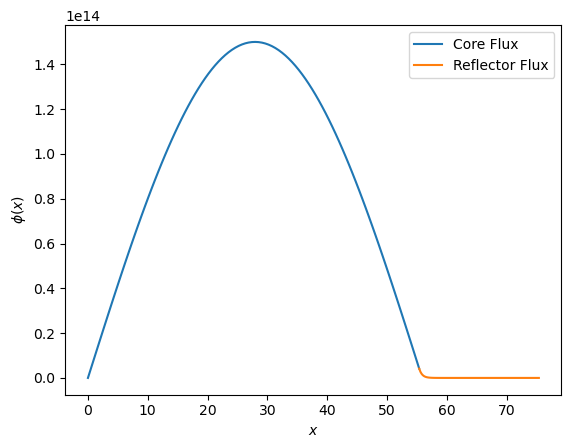

In [11]:

################################################################################
# Plotting
################################################################################
# Space
x_1 = np.linspace(Core_1.Start, Core_1.End, 100)
x_2 = np.linspace(Reflector_1.Start, Reflector_1.Start+20, 100)

# Evaluation
phi1_vals = [phi1.subs(x, val).evalf() for val in x_1]
phi2_vals = [phi2.subs(x, val).evalf() for val in x_2]

# Plot
plt.plot(x_1, phi1_vals, label='Core Flux')
plt.plot(x_2, phi2_vals, label='Reflector Flux')
plt.xlabel('$x$')
plt.ylabel('$\phi(x)$')
plt.legend()
plt.show()